In [1]:
print("Hiran MM21B030")

Hiran MM21B030


# Loading Dataset

200


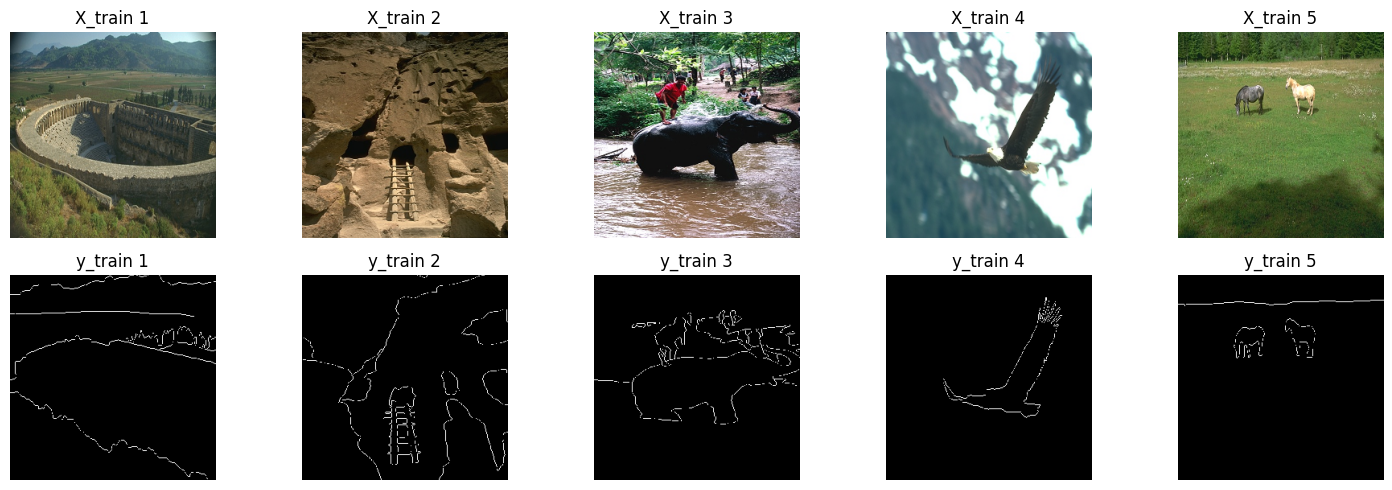

<Figure size 640x480 with 0 Axes>

In [1]:
import os 
import matplotlib.pyplot as plt
import cv2
import numpy as np
import scipy

images_dir = "./BSR/BSDS500/data/images"
groundTruth_dir = "./BSR/BSDS500/data/groundTruth"

train_image_dir = os.path.join(images_dir, "train")
train_groundTruth_dir = os.path.join(groundTruth_dir, "train")


X_train = []
y_train = []
for file in os.listdir(train_image_dir):
    image = cv2.imread(os.path.join(train_image_dir, file))
    image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    file = file[:len(file)-4] + '.mat'                                  # Changing the filename for equivalent groundTruth
    try: 
        groundTruth = scipy.io.loadmat(os.path.join(train_groundTruth_dir, file))['groundTruth'][0][0]['Boundaries'][0][0]
        groundTruth = cv2.resize(groundTruth, (256, 256), interpolation=cv2.INTER_CUBIC)
        X_train.append(image)                                           # Reading .mat file
        y_train.append(groundTruth)
    except Exception as e:
        print(e)


val_image_dir = os.path.join(images_dir, "val")
val_groundTruth_dir = os.path.join(groundTruth_dir, "val")


X_val = []
y_val = []
for file in os.listdir(val_image_dir):
    image = cv2.imread(os.path.join(val_image_dir, file))
    image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    file = file[:len(file)-4] + '.mat'                                  # Changing the filename for equivalent groundTruth
    try: 
        groundTruth = scipy.io.loadmat(os.path.join(val_groundTruth_dir, file))['groundTruth'][0][0]['Boundaries'][0][0]
        groundTruth = cv2.resize(groundTruth, (256, 256), interpolation=cv2.INTER_CUBIC)
        X_val.append(image)                                           # Reading .mat file
        y_val.append(groundTruth)
    except Exception as e:
        print(e)
        

test_image_dir = os.path.join(images_dir, "test")
test_groundTruth_dir = os.path.join(groundTruth_dir, "test")


X_test = []
y_test = []
for file in os.listdir(test_image_dir):
    image = cv2.imread(os.path.join(test_image_dir, file))
    image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    file = file[:len(file)-4] + '.mat'                                  # Changing the filename for equivalent groundTruth
    try: 
        groundTruth = scipy.io.loadmat(os.path.join(test_groundTruth_dir, file))['groundTruth'][0][0]['Boundaries'][0][0]
        groundTruth = cv2.resize(groundTruth, (256, 256), interpolation=cv2.INTER_CUBIC)
        X_test.append(image)                                           # Reading .mat file
        y_test.append(groundTruth)
    except Exception as e:
        print(e)
    

print(len(X_train))
fig, ax = plt.subplots(2, 5, figsize=(15, 5))


for i in range(5):
    ax[0, i].imshow(X_train[i])  # Plot from X_train
    ax[0, i].axis('off')
    ax[0, i].set_title(f"X_train {i+1}")

    ax[1, i].imshow(y_train[i], cmap = 'gray')  # Plot from y_train
    ax[1, i].axis('off')
    ax[1, i].set_title(f"y_train {i+1}")

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()


# Task 1: Canny Edge Detection

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve

def rgb2gray(image):
    """Convert RGB image to grayscale."""
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])

def sobel_filters(image):
    """Compute Sobel gradients."""
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    Gx = convolve(image, Kx)
    Gy = convolve(image, Ky)

    G = np.hypot(Gx, Gy)  # Gradient magnitude
    theta = np.arctan2(Gy, Gx)  # Gradient direction

    return G, theta

def non_maximum_suppression(gradient, theta):
    """
    Apply Non-Maximum Suppression to an image gradient.
    Args:
        gradient (np.ndarray): Gradient magnitude.
        theta (np.ndarray): Gradient direction in radians.
    Returns:
        np.ndarray: Suppressed gradient.
    """
    rows, cols = gradient.shape
    suppressed = np.zeros_like(gradient)

    # Convert theta from radians to degrees
    theta_deg = np.degrees(theta)
    theta_deg[theta_deg < 0] += 180  # Convert to range [0, 180]

    # Quantize angles to 0°, 45°, 90°, or 135°
    theta_quantized = np.round(theta_deg / 45) * 45
    theta_quantized[theta_quantized == 180] = 0  # Normalize 180° to 0°

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            q, r = 255, 255  # Default high value for suppression errors

            # Edge direction cases
            if theta_quantized[i, j] == 0:  # Horizontal (0°)
                q = gradient[i, j + 1]  # Right
                r = gradient[i, j - 1]  # Left
            elif theta_quantized[i, j] == 45:  # Diagonal (45°)
                q = gradient[i - 1, j + 1]  # Top-right
                r = gradient[i + 1, j - 1]  # Bottom-left
            elif theta_quantized[i, j] == 90:  # Vertical (90°)
                q = gradient[i + 1, j]  # Bottom
                r = gradient[i - 1, j]  # Top
            elif theta_quantized[i, j] == 135:  # Diagonal (135°)
                q = gradient[i + 1, j + 1]  # Bottom-right
                r = gradient[i - 1, j - 1]  # Top-left

            # Keep only local maxima
            if gradient[i, j] >= q and gradient[i, j] >= r:
                suppressed[i, j] = gradient[i, j]

    return suppressed

def threshold(image, low, high):
    """Apply double thresholding."""
    strong = 255
    weak = 75

    strong_i, strong_j = np.where(image >= high)
    weak_i, weak_j = np.where((image <= high) & (image >= low))

    output = np.zeros_like(image, dtype=np.uint8)
    output[strong_i, strong_j] = strong
    output[weak_i, weak_j] = weak

    return output, strong, weak

def hysteresis(image, strong, weak):
    """
    Apply edge tracking by hysteresis with an 8-connected neighborhood.
    Args:
        image (np.ndarray): Input edge-detected image.
        strong (int): Pixel value representing a strong edge.
        weak (int): Pixel value representing a weak edge.
    Returns:
        np.ndarray: Output image with edges connected using hysteresis.
    """
    rows, cols = image.shape
    output = np.copy(image)  # Copy of the original image

    # Get indices of strong edges
    strong_i, strong_j = np.where(image == strong)
    
    # Run a BFS-like approach using a stack
    stack = list(zip(strong_i, strong_j))

    while stack:
        i, j = stack.pop()

        # Check 8-connected neighbors
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                ni, nj = i + di, j + dj

                # Boundary check
                if 0 <= ni < rows and 0 <= nj < cols:
                    # If a weak edge is connected to a strong edge
                    if output[ni, nj] == weak:
                        output[ni, nj] = strong  # Promote to strong edge
                        stack.append((ni, nj))  # Continue tracking

    # Remove remaining weak edges
    output[output == weak] = 0
    
    return output
def canny_edge_detection(image, sigma=1.4, low=20, high=40):
    """Full Canny Edge Detection Pipeline."""
    gray = rgb2gray(image)
    blurred = gaussian_filter(gray, sigma)
    gradient, theta = sobel_filters(blurred)
    suppressed = non_maximum_suppression(gradient, theta)
    thresholded, strong, weak = threshold(suppressed, low, high)
    final_edges = hysteresis(thresholded, strong, weak)

    return final_edges

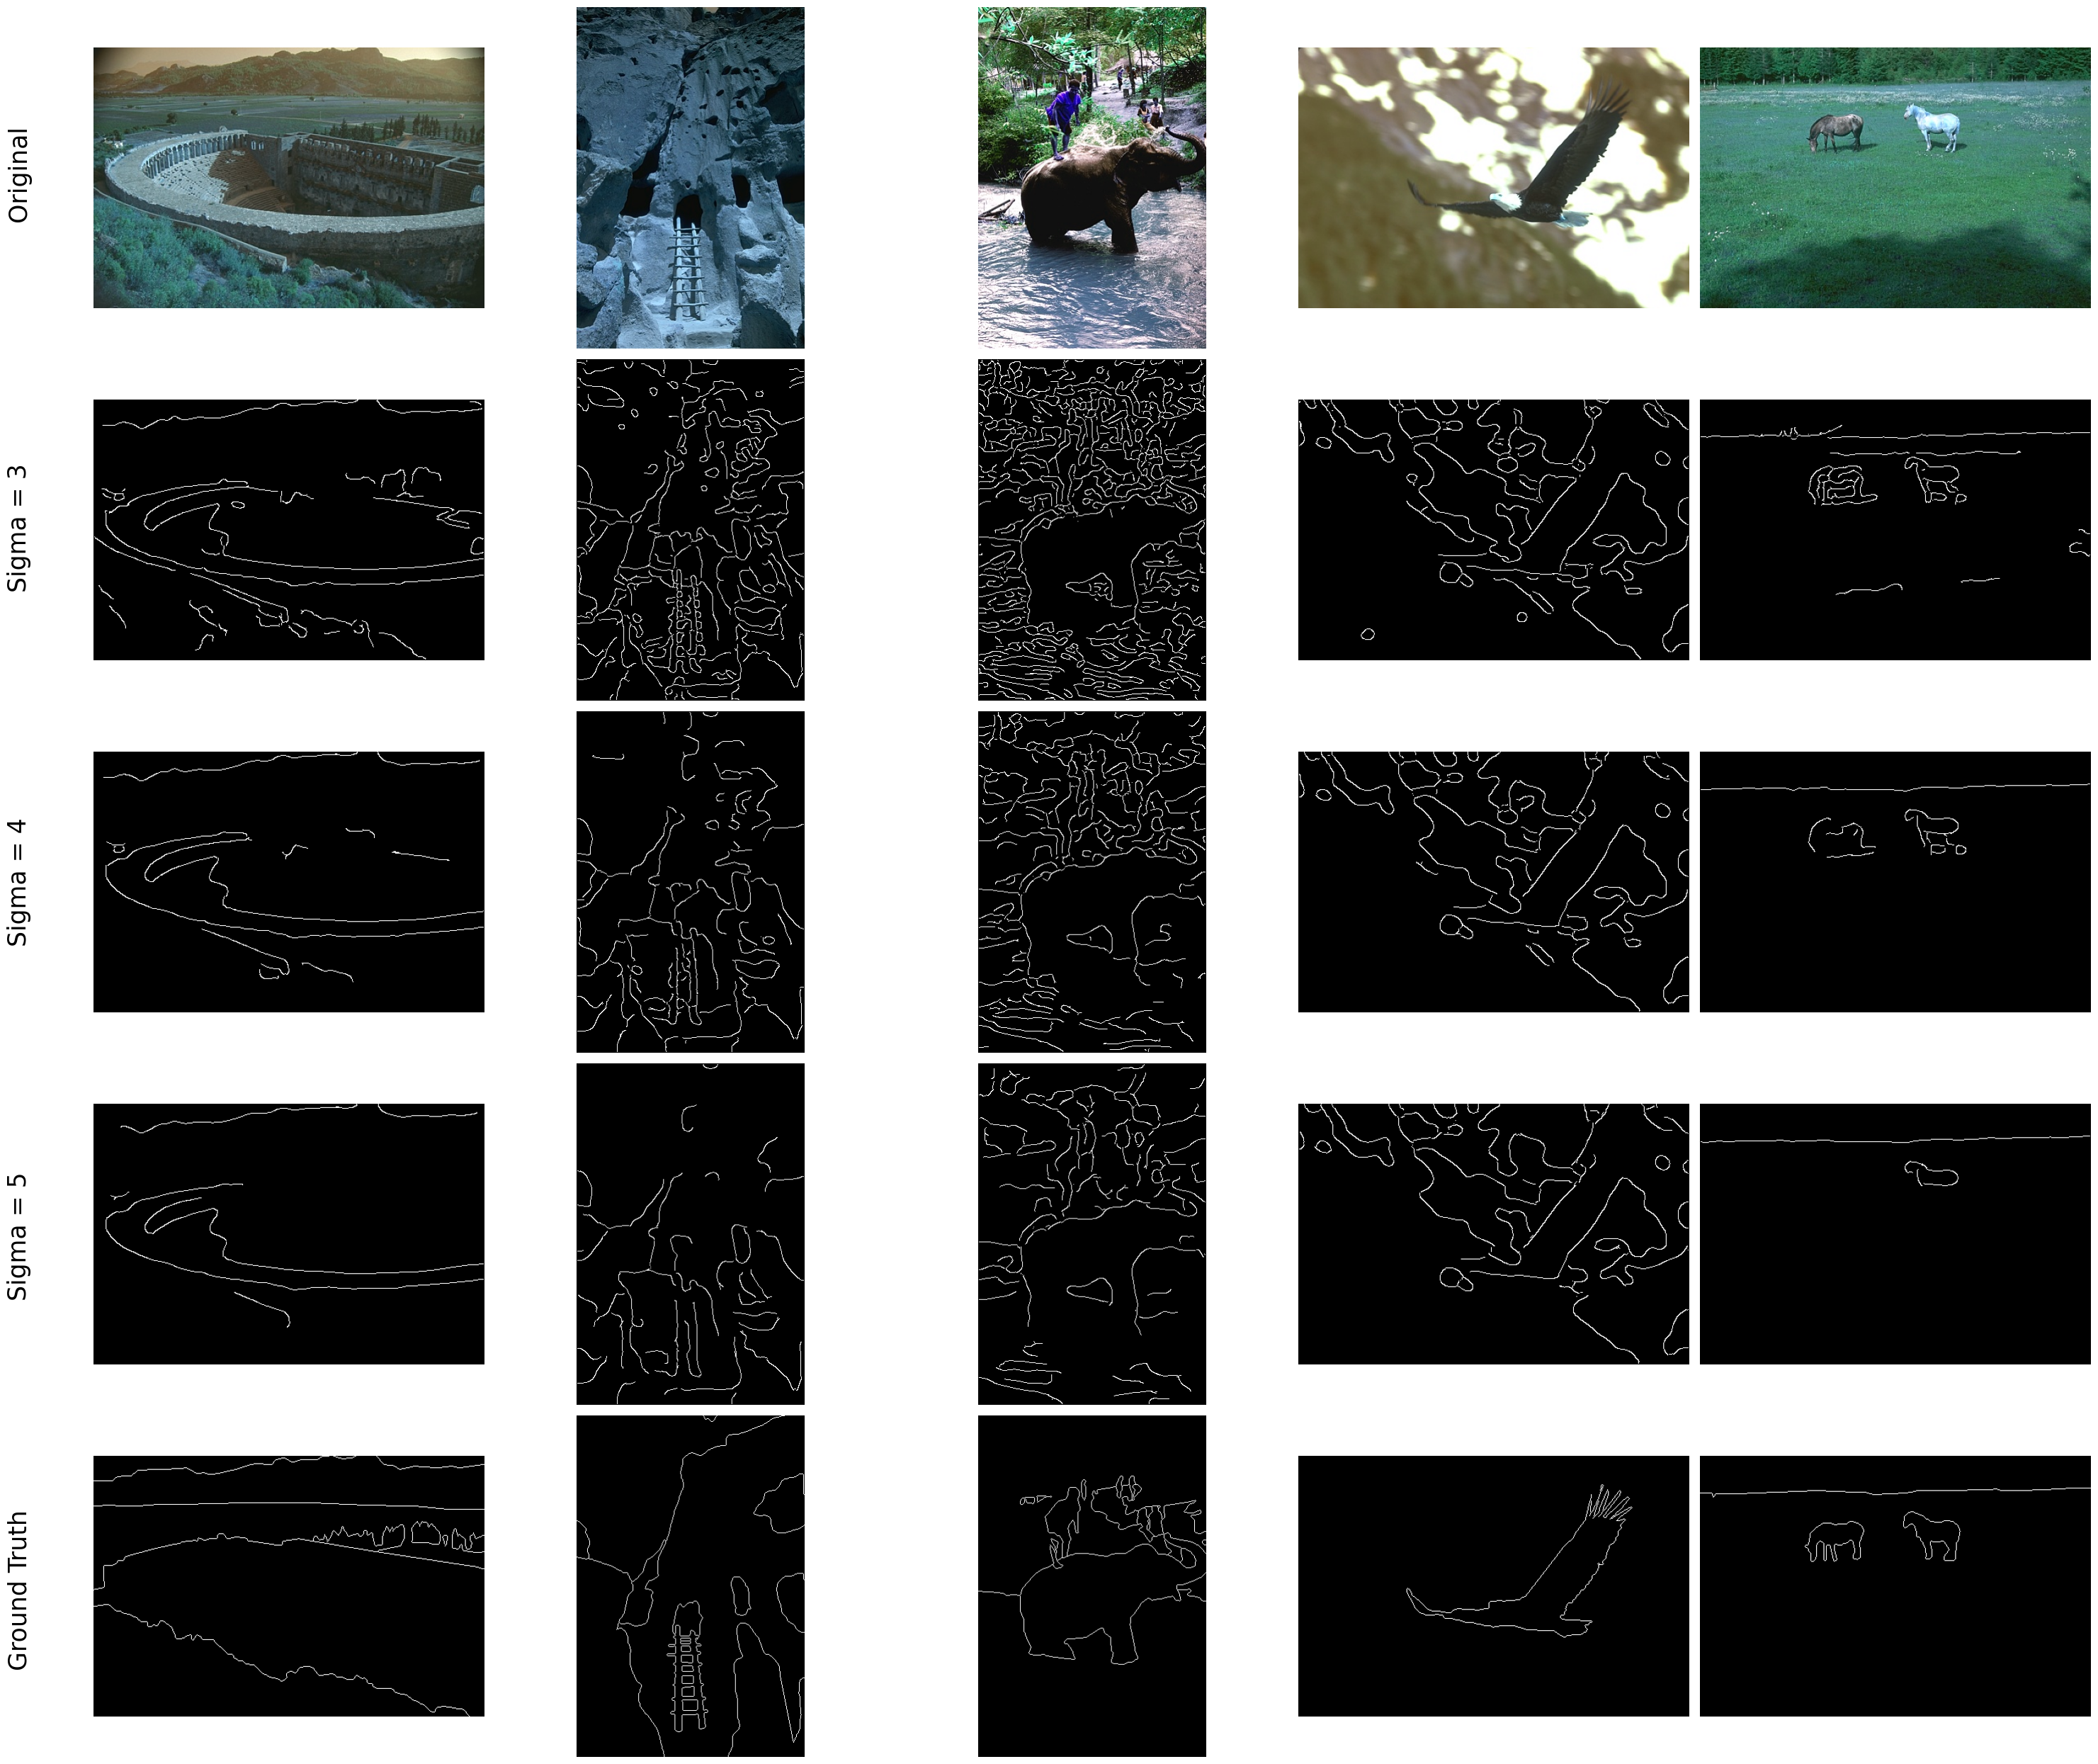

<Figure size 640x480 with 0 Axes>

In [18]:
fig, ax = plt.subplots(5, 5, figsize=(30, 25))

# Row Titles
row_titles = ["Original", "Sigma = 3", "Sigma = 4", "Sigma = 5", "Ground Truth"]

# Set Row Titles
for i in range(5):
    fig.text(0.02, 1 - (i + 0.5) / 5, row_titles[i], va='center', ha='center', fontsize=25, rotation=90)

# Plot Images
for i in range(5):
    ax[0, i].imshow(X_train[i])
    ax[0, i].axis('off')

    ax[1, i].imshow(canny_edge_detection(X_train[i], 3), cmap='gray')
    ax[1, i].axis('off')

    ax[2, i].imshow(canny_edge_detection(X_train[i], 4), cmap='gray')
    ax[2, i].axis('off')

    ax[3, i].imshow(canny_edge_detection(X_train[i], 5), cmap='gray')
    ax[3, i].axis('off')

    ax[4, i].imshow(y_train[i], cmap='gray')
    ax[4, i].axis('off')

plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()

plt.tight_layout()
plt.show()



#### While the Canny edge detector shows promise, it is highly image-specific. For instance, certain values of the sigma parameter work better for some images than others, and the resulting edges often include a significant amount of noise. Although it is possible to fine-tune the detector by adjusting other parameters, such as the low and high thresholds, this process remains heavily dependent on the specific characteristics of each image.

# Task 2: Simple CNN Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Device configuration (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 100
batch_size = 32
learning_rate = 0.001

# Resize and normalise. Coz after resizing pixel values go out of (0 to 1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))
])

# This transform is for labels
transform_won = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Lambda(lambda x: (x > 0).float())  # Apply threshold
                    
])

# Apply transformations
X_train_tensor = torch.stack([transform(img) for img in X_train])
y_train_tensor = torch.stack([transform_won(edge) for edge in y_train])

X_val_tensor = torch.stack([transform(img) for img in X_val])
y_val_tensor = torch.stack([transform_won(edge) for edge in y_val])

X_test_tensor = torch.stack([transform(img) for img in X_test])
y_test_tensor = torch.stack([transform_won(edge) for edge in y_test])

# Create TensorDatasets
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Define CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)  # Input Channels=3 (RGB), Output=8
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return torch.sigmoid(x)  # Apply sigmoid for values between 0 and 1

model = SimpleCNN().to(device)

# Loss and Optimizer
def compute_beta(y_true):
    # Calculate the beta using the number of edge pixels (1) and non-edge pixels (0)
    edge_pixels = torch.sum(y_true)
    total_pixels = y_true.numel()
    beta = edge_pixels / total_pixels
    
    # Define weights based on beta
    weights = torch.tensor([beta, 1 - beta], dtype=torch.float32).to(y_true.device)
    return weights
print("Beta, 1 - Beta", compute_beta(y_train_tensor))
class_weights = compute_beta(y_train_tensor)

# Create pos_weight for BCEWithLogitsLoss
pos_weight = torch.tensor([class_weights[1] / class_weights[0]])

# Define loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# Initialize lists to store losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    # Training Loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Calculate and store average training loss
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Loop
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')



Beta, 1 - Beta tensor([0.0601, 0.9399])
Epoch [1/100], Train Loss: 0.7161, Val Loss: 0.6883
Epoch [2/100], Train Loss: 0.6602, Val Loss: 0.6124
Epoch [3/100], Train Loss: 0.5627, Val Loss: 0.4736
Epoch [4/100], Train Loss: 0.4216, Val Loss: 0.3215
Epoch [5/100], Train Loss: 0.2973, Val Loss: 0.2575
Epoch [6/100], Train Loss: 0.2717, Val Loss: 0.2642
Epoch [7/100], Train Loss: 0.2723, Val Loss: 0.2627
Epoch [8/100], Train Loss: 0.2674, Val Loss: 0.2531
Epoch [9/100], Train Loss: 0.2623, Val Loss: 0.2478
Epoch [10/100], Train Loss: 0.2527, Val Loss: 0.2457
Epoch [11/100], Train Loss: 0.2534, Val Loss: 0.2433
Epoch [12/100], Train Loss: 0.2476, Val Loss: 0.2409
Epoch [13/100], Train Loss: 0.2479, Val Loss: 0.2380
Epoch [14/100], Train Loss: 0.2487, Val Loss: 0.2346
Epoch [15/100], Train Loss: 0.2411, Val Loss: 0.2312
Epoch [16/100], Train Loss: 0.2417, Val Loss: 0.2281
Epoch [17/100], Train Loss: 0.2329, Val Loss: 0.2251
Epoch [18/100], Train Loss: 0.2342, Val Loss: 0.2231
Epoch [19/100],

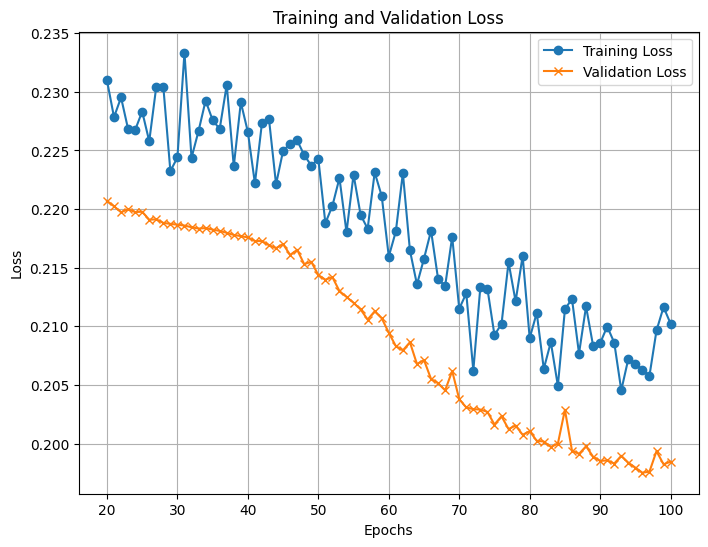

In [36]:
# Plot Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(range(20, num_epochs+1), train_losses[19:], label='Training Loss', marker='o')
plt.plot(range(20, num_epochs+1), val_losses[19:], label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


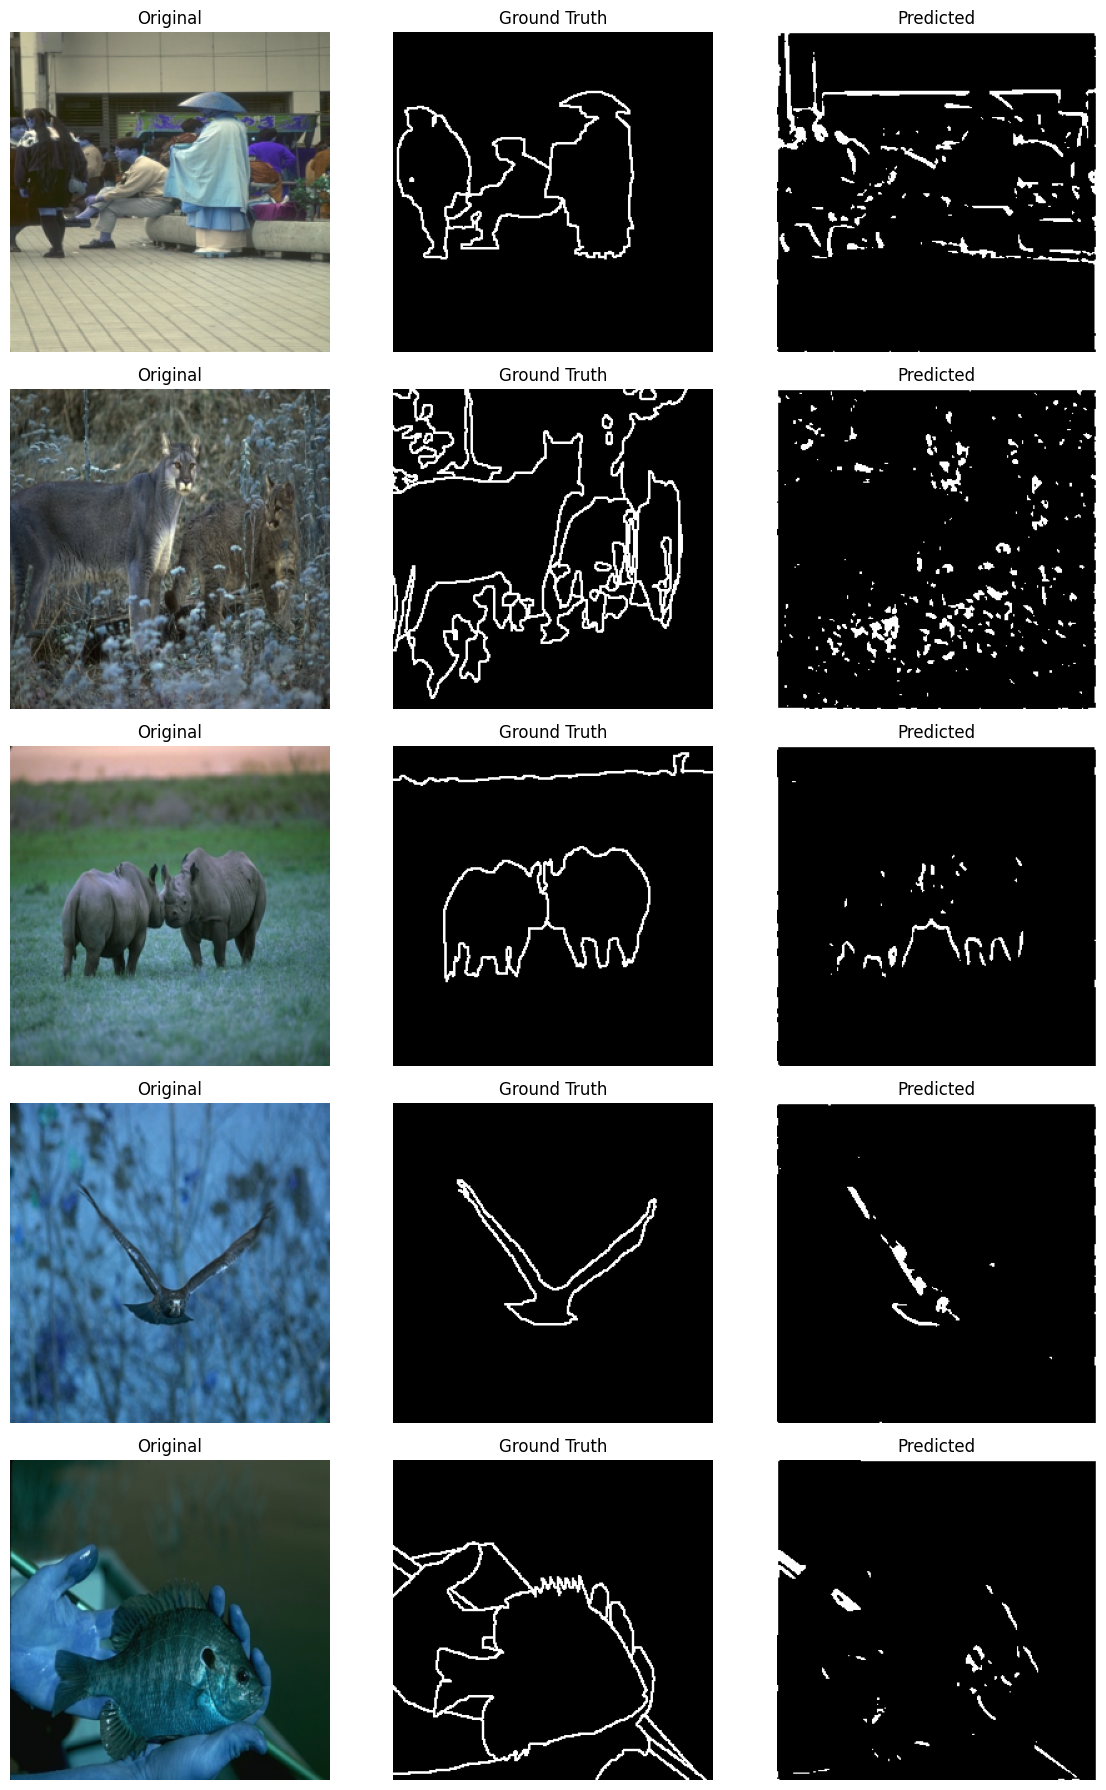

In [39]:
import torch
import matplotlib.pyplot as plt

# Select the first 5 test images
model.eval()
images, labels = next(iter(test_loader))
images, labels = images[:5].to(device), labels[:5].to(device)

# Make predictions
with torch.no_grad():
    outputs = model(images)
    predictions = (outputs > 0.1) 

# Convert tensors to numpy for visualization
images = images.cpu().permute(0, 2, 3, 1).numpy()
labels = labels.cpu().squeeze().numpy()
predictions = predictions.cpu().squeeze().numpy()

# Plot Original, Ground Truth, and Predicted
fig, axes = plt.subplots(5, 3, figsize=(12, 18))

for i in range(5):
    # Original Image
    axes[i, 0].imshow(images[i])
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original')

    # Ground Truth
    axes[i, 1].imshow(labels[i], cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Ground Truth')

    # Predicted
    axes[i, 2].imshow(predictions[i], cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Predicted')

plt.tight_layout()
plt.show()


# Task 3: VGG16 Model

## a) Transpose Upscaling

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision.models import vgg16, VGG16_Weights

import torchvision.transforms as transforms

# Device configuration (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Transforming here no resizing because I have resized the images in the loading step
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



transform_won = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0).float())  # Apply threshold
])


class VGG16Decoder(nn.Module):
    def __init__(self, upsampling_method='transpose_conv'):
        super(VGG16Decoder, self).__init__()
        
        # Load pre-trained VGG16 without the last max-pooling layer and FC layers
        vgg16_model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        self.encoder = nn.Sequential(*list(vgg16_model.features.children())[:-1])  # Remove last maxpool
        
        # Decoder network using transposed convolutions
        if upsampling_method == 'transpose_conv':
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.Sigmoid()  # Normalize output between 0 and 1
            )
        
        # Decoder using bilinear upsampling
        elif upsampling_method == 'bilinear':
            self.decoder = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(512, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(256, 128, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(128, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(64, 1, kernel_size=3, padding=1),
                nn.Sigmoid()  # Normalize output between 0 and 1
            )
        else:
            raise ValueError("Invalid upsampling method. Choose 'transpose_conv' or 'bilinear'")
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Hyperparameters
num_epochs = 30
batch_size = 16
learning_rate = 0.0001

# Apply transformations
X_train_tensor = torch.stack([transform(img) for img in X_train])
y_train_tensor = torch.stack([transform_won(edge) for edge in y_train])

X_val_tensor = torch.stack([transform(img) for img in X_val])
y_val_tensor = torch.stack([transform_won(edge) for edge in y_val])



# Create TensorDatasets
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)


# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



model_trans = VGG16Decoder(upsampling_method='transpose_conv').to(device)

del X_train_tensor, X_val_tensor, y_val_tensor , train_dataset, val_dataset 
torch.cuda.empty_cache()



model = model_trans.to(device)


# Loss and Optimizer
def compute_beta(y_true):
    # Calculate the beta using the number of edge pixels (1) and non-edge pixels (0)
    edge_pixels = torch.sum(y_true)
    total_pixels = y_true.numel()
    beta = edge_pixels / total_pixels
    
    # Define weights based on beta
    weights = torch.tensor([beta, 1 - beta], dtype=torch.float32).to(y_true.device)
    return weights
print("Beta, 1 - Beta", compute_beta(y_train_tensor))
class_weights = compute_beta(y_train_tensor)

# Create pos_weight for BCEWithLogitsLoss
pos_weight = torch.tensor([class_weights[1] / class_weights[0]])

# Define loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = optim.NAdam(model.parameters(), lr=learning_rate)


# Initialize lists to store losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    # Training Loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Calculate and store average training loss
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Loop
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')



Beta, 1 - Beta tensor([0.0186, 0.9814])
Epoch [1/30], Train Loss: 1.3947, Val Loss: 1.3701
Epoch [2/30], Train Loss: 1.3281, Val Loss: 1.3041
Epoch [3/30], Train Loss: 1.2998, Val Loss: 1.2899
Epoch [4/30], Train Loss: 1.2950, Val Loss: 1.2887
Epoch [5/30], Train Loss: 1.2837, Val Loss: 1.2839
Epoch [6/30], Train Loss: 1.2729, Val Loss: 1.2754
Epoch [7/30], Train Loss: 1.2605, Val Loss: 1.2572
Epoch [8/30], Train Loss: 1.2384, Val Loss: 1.2588
Epoch [9/30], Train Loss: 1.2218, Val Loss: 1.2579
Epoch [10/30], Train Loss: 1.2172, Val Loss: 1.2436
Epoch [11/30], Train Loss: 1.2106, Val Loss: 1.2366
Epoch [12/30], Train Loss: 1.1860, Val Loss: 1.2331
Epoch [13/30], Train Loss: 1.1877, Val Loss: 1.2331
Epoch [14/30], Train Loss: 1.1760, Val Loss: 1.2288
Epoch [15/30], Train Loss: 1.1713, Val Loss: 1.2389
Epoch [16/30], Train Loss: 1.1619, Val Loss: 1.2266
Epoch [17/30], Train Loss: 1.1580, Val Loss: 1.2257
Epoch [18/30], Train Loss: 1.1773, Val Loss: 1.2267
Epoch [19/30], Train Loss: 1.1539

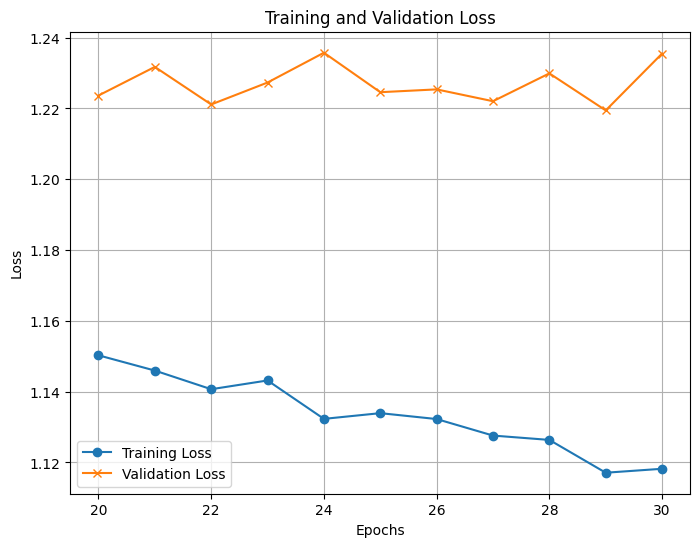

In [78]:
# Plot Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(range(20, num_epochs+1), train_losses[19:], label='Training Loss', marker='o')
plt.plot(range(20, num_epochs+1), val_losses[19:], label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5870366..2.343704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.0262864].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].


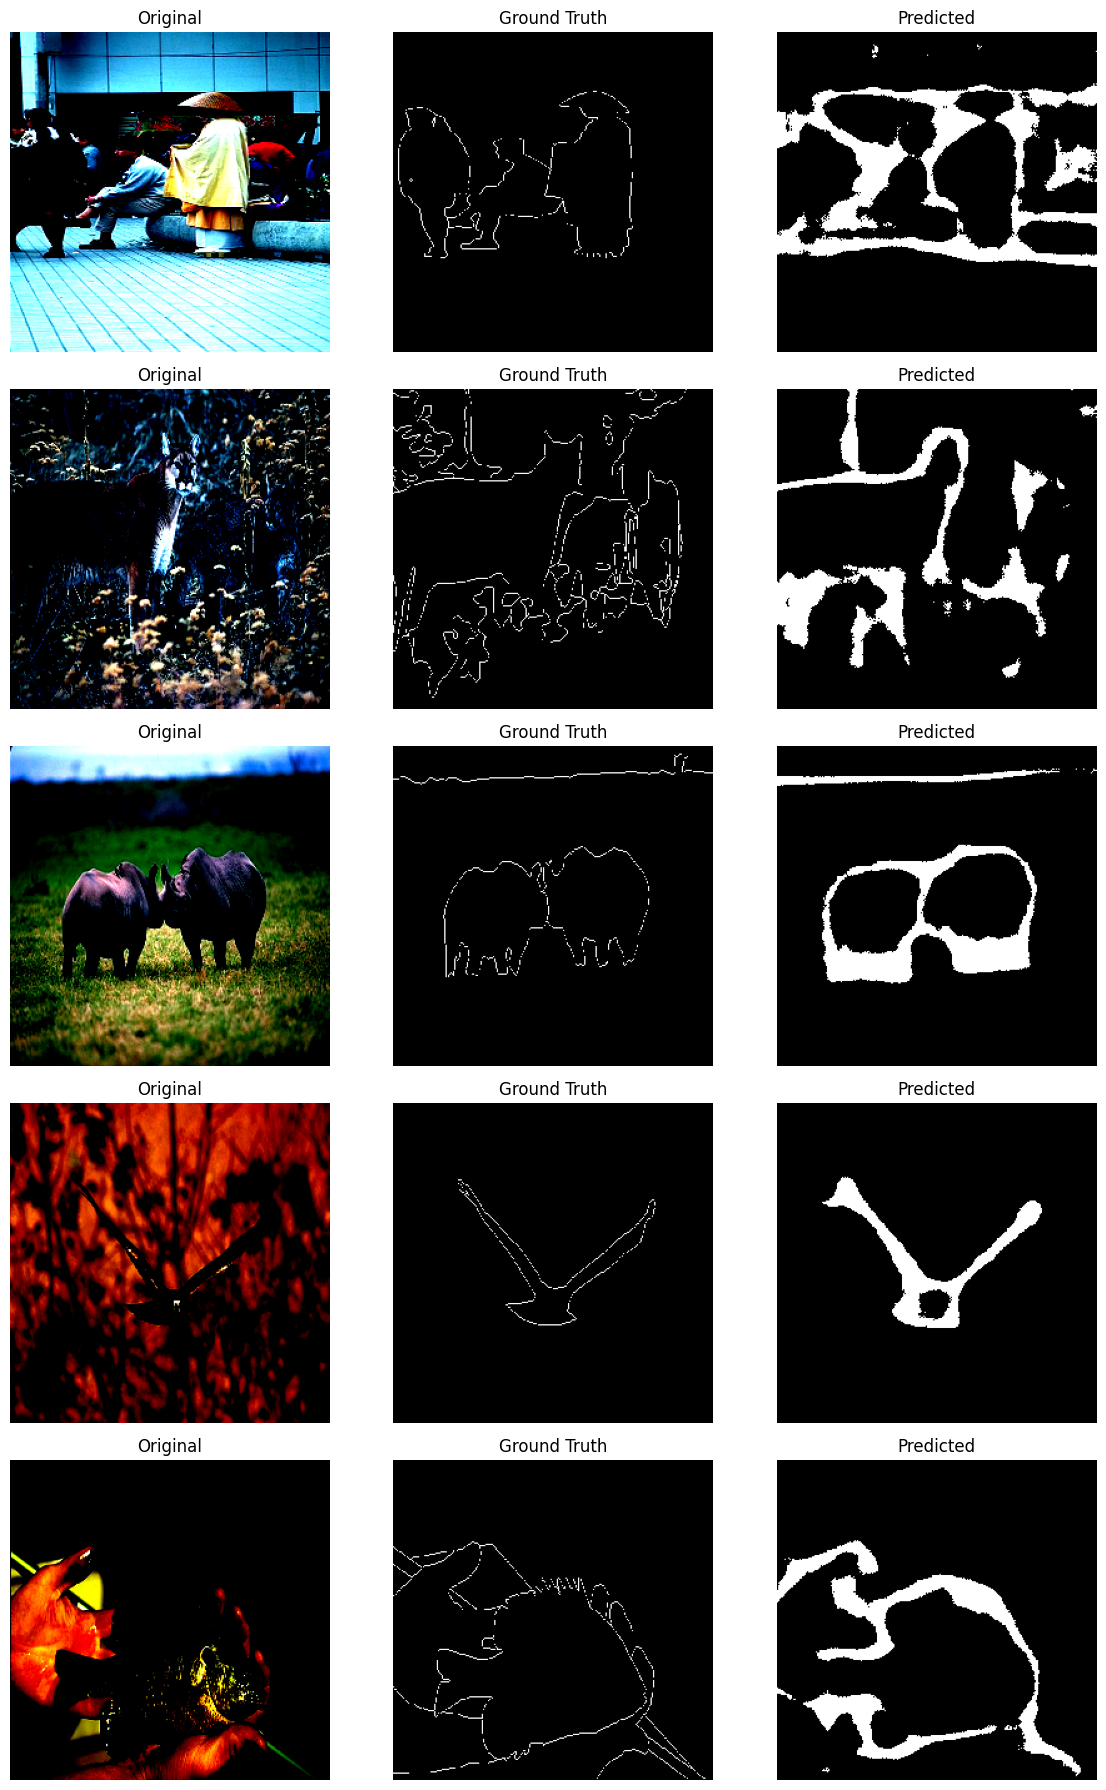

In [81]:
import torch
import matplotlib.pyplot as plt


X_test_tensor = torch.stack([transform(img) for img in X_test])
y_test_tensor = torch.stack([transform_won(edge) for edge in y_test])
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
del X_test_tensor, y_test_tensor, test_dataset
# Select the first 5 test images
model.eval()
images, labels = next(iter(test_loader))
images, labels = images[:5].to(device), labels[:5].to(device)

# Make predictions
with torch.no_grad():
    outputs = model(images)
    predictions = (outputs > 0.5) 

# Convert tensors to numpy for visualization
images = images.cpu().permute(0, 2, 3, 1).numpy()
labels = labels.cpu().squeeze().numpy()
predictions = predictions.cpu().squeeze().numpy()

# Plot Original, Ground Truth, and Predicted
fig, axes = plt.subplots(5, 3, figsize=(12, 18))

for i in range(5):
    # Original Image
    axes[i, 0].imshow(images[i])
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original')

    # Ground Truth
    axes[i, 1].imshow(labels[i], cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Ground Truth')

    # Predicted
    axes[i, 2].imshow(predictions[i], cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Predicted')

plt.tight_layout()
plt.show()


In [85]:
import gc
import torch

# Delete all variables
for obj in list(globals()):
    if isinstance(globals()[obj], torch.Tensor) or isinstance(globals()[obj], torch.nn.Module):
        del globals()[obj]

# Run garbage collection
gc.collect()
torch.cuda.empty_cache()  # Clear PyTorch cache

## b) Bilinear Upscaling

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision.models import vgg16, VGG16_Weights

import torchvision.transforms as transforms

# Device configuration (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Efficient transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



transform_won = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0).float())  # Apply threshold
])


class VGG16Decoder(nn.Module):
    def __init__(self, upsampling_method='transpose_conv'):
        super(VGG16Decoder, self).__init__()
        
        # Load pre-trained VGG16 without the last max-pooling layer and FC layers
        vgg16_model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        self.encoder = nn.Sequential(*list(vgg16_model.features.children())[:-1])  # Remove last maxpool
        
        # Decoder network using transposed convolutions
        if upsampling_method == 'transpose_conv':
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.Sigmoid()  # Normalize output between 0 and 1
            )
        
        # Decoder using bilinear upsampling
        elif upsampling_method == 'bilinear':
            self.decoder = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(512, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(256, 128, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(128, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(64, 1, kernel_size=3, padding=1),
                nn.Sigmoid()  # Normalize output between 0 and 1
            )
        else:
            raise ValueError("Invalid upsampling method. Choose 'transpose_conv' or 'bilinear'")
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Hyperparameters
num_epochs = 20
batch_size = 16
learning_rate = 0.0001

# Apply transformations
X_train_tensor = torch.stack([transform(img) for img in X_train])
y_train_tensor = torch.stack([transform_won(edge) for edge in y_train])

X_val_tensor = torch.stack([transform(img) for img in X_val])
y_val_tensor = torch.stack([transform_won(edge) for edge in y_val])



# Create TensorDatasets
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)


# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



model_bilinear = VGG16Decoder(upsampling_method='bilinear').to(device)

del X_train_tensor, X_val_tensor, y_val_tensor , train_dataset, val_dataset 
torch.cuda.empty_cache()



model = model_bilinear.to(device)

# Loss and Optimizer
def compute_beta(y_true):
    # Calculate the beta using the number of edge pixels (1) and non-edge pixels (0)
    edge_pixels = torch.sum(y_true)
    total_pixels = y_true.numel()
    beta = edge_pixels / total_pixels
    
    # Define weights based on beta
    weights = torch.tensor([beta, 1 - beta], dtype=torch.float32).to(y_true.device)
    return weights
print("Beta, 1 - Beta", compute_beta(y_train_tensor))
class_weights = compute_beta(y_train_tensor)

# Create pos_weight for BCEWithLogitsLoss
pos_weight = torch.tensor([class_weights[1] / class_weights[0]])

# Define loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = optim.NAdam(model.parameters(), lr=learning_rate)


# Initialize lists to store losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    # Training Loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Calculate and store average training loss
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Loop
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

Beta, 1 - Beta tensor([0.0186, 0.9814])
Epoch [1/20], Train Loss: 1.3538, Val Loss: 1.3241
Epoch [2/20], Train Loss: 1.3097, Val Loss: 1.2840
Epoch [3/20], Train Loss: 1.2736, Val Loss: 1.2723
Epoch [4/20], Train Loss: 1.2614, Val Loss: 1.2648
Epoch [5/20], Train Loss: 1.2379, Val Loss: 1.2643
Epoch [6/20], Train Loss: 1.2463, Val Loss: 1.2609
Epoch [7/20], Train Loss: 1.2279, Val Loss: 1.2536
Epoch [8/20], Train Loss: 1.2249, Val Loss: 1.2580
Epoch [9/20], Train Loss: 1.2067, Val Loss: 1.2619
Epoch [10/20], Train Loss: 1.2097, Val Loss: 1.2498
Epoch [11/20], Train Loss: 1.1983, Val Loss: 1.2501
Epoch [12/20], Train Loss: 1.1939, Val Loss: 1.2602
Epoch [13/20], Train Loss: 1.1910, Val Loss: 1.2477
Epoch [14/20], Train Loss: 1.1866, Val Loss: 1.2502
Epoch [15/20], Train Loss: 1.1866, Val Loss: 1.2490
Epoch [16/20], Train Loss: 1.1732, Val Loss: 1.2465
Epoch [17/20], Train Loss: 1.1756, Val Loss: 1.2448
Epoch [18/20], Train Loss: 1.1679, Val Loss: 1.2455
Epoch [19/20], Train Loss: 1.1726

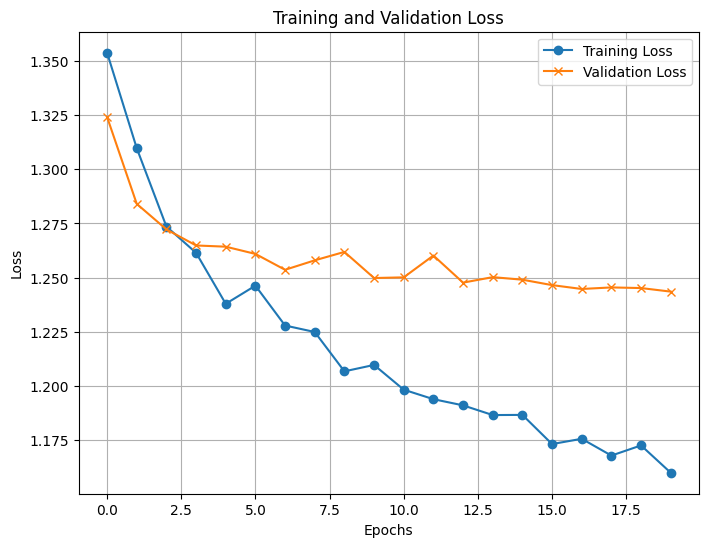

In [51]:
# Plot Loss Curve
plt.figure(figsize=(8, 6))
plt.plot(range(num_epochs), train_losses, label='Training Loss', marker='o')
plt.plot(range(num_epochs), val_losses, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5870366..2.343704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.0262864].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4285715].


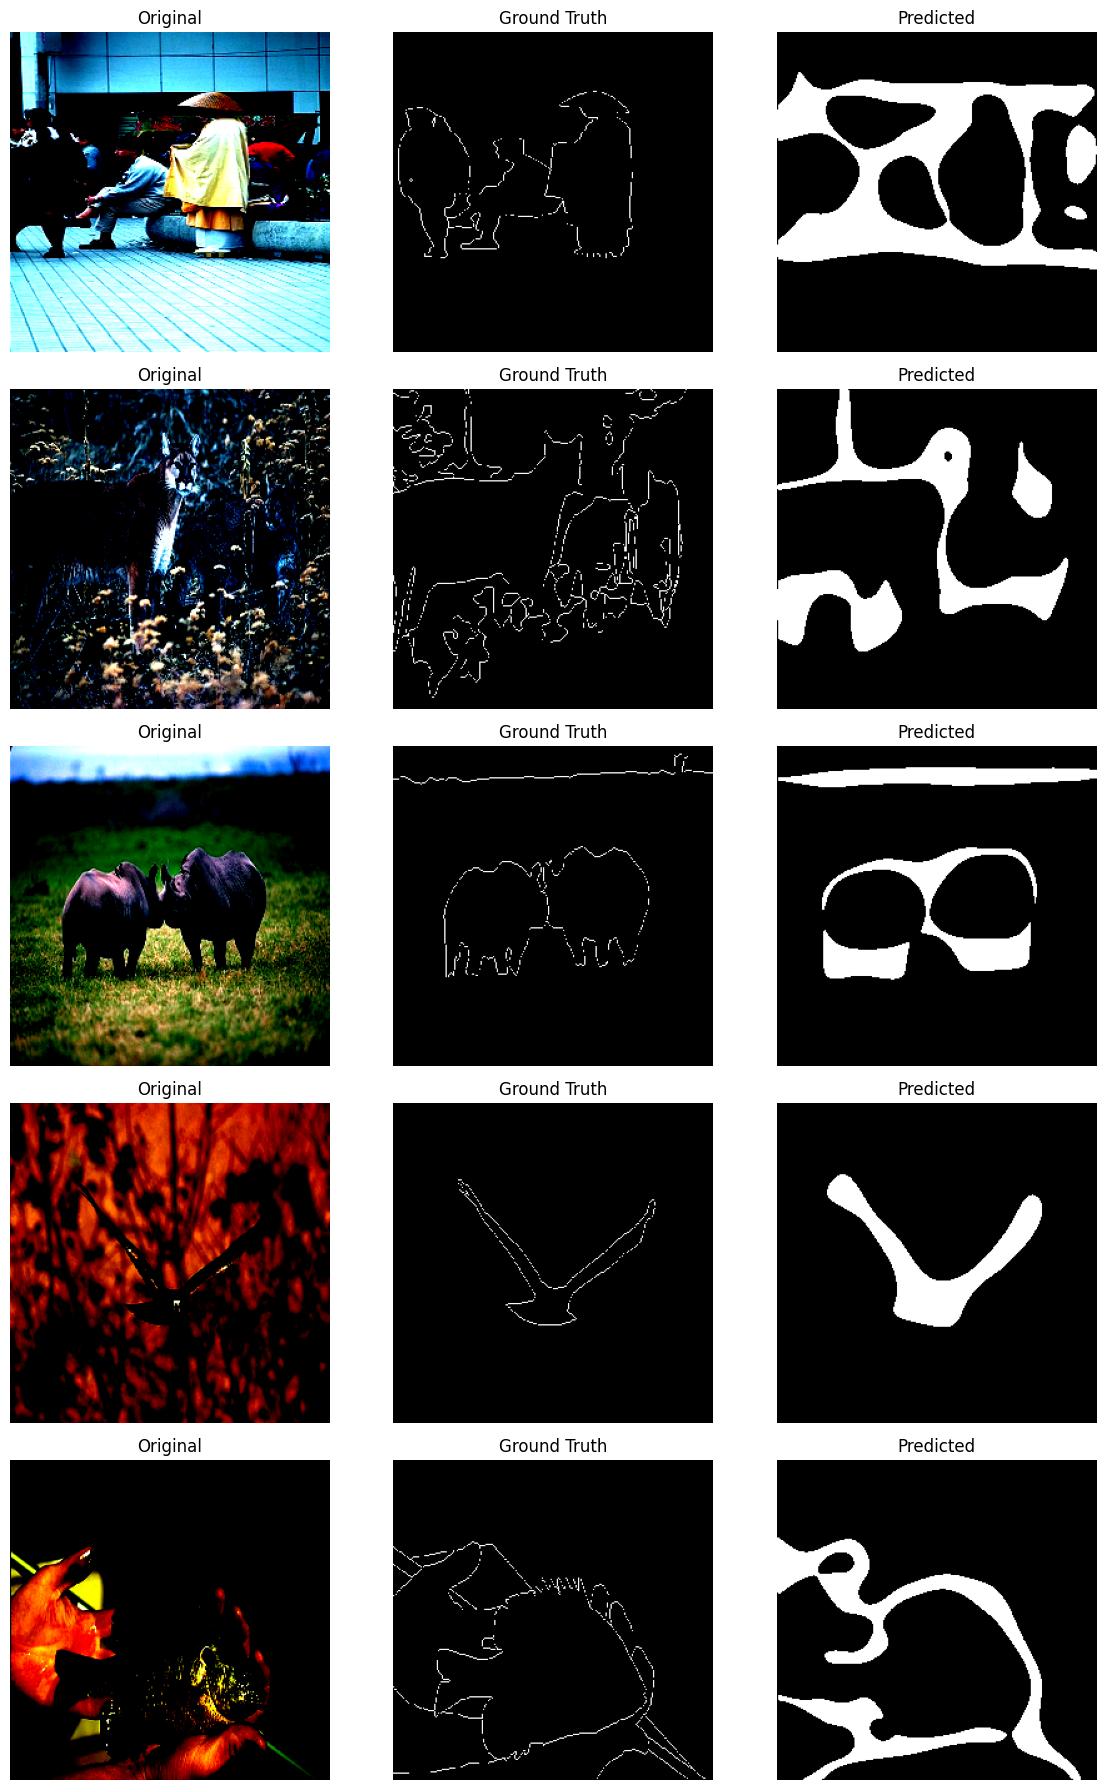

In [63]:
import torch
import matplotlib.pyplot as plt

X_test_tensor = torch.stack([transform(img) for img in X_test])
y_test_tensor = torch.stack([transform_won(edge) for edge in y_test])
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
del X_test_tensor, y_test_tensor

# Select the first 5 test images
model.eval()
images, labels = next(iter(test_loader))
images, labels = images[:5].to(device), labels[:5].to(device)

# Make predictions
with torch.no_grad():
    outputs = model(images)
    predictions = (outputs > 0.8) 

# Convert tensors to numpy for visualization
images = images.cpu().permute(0, 2, 3, 1).numpy()
labels = labels.cpu().squeeze().numpy()
predictions = predictions.cpu().squeeze().numpy()

# Plot Original, Ground Truth, and Predicted
fig, axes = plt.subplots(5, 3, figsize=(12, 18))

for i in range(5):
    # Original Image
    axes[i, 0].imshow(images[i])
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original')

    # Ground Truth
    axes[i, 1].imshow(labels[i], cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Ground Truth')

    # Predicted
    axes[i, 2].imshow(predictions[i], cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Predicted')

plt.tight_layout()
plt.show()




### Observations so far, 
#### 1. Loss Function and Activation Function

    Loss Function:

        The loss function used is Binary Cross Entropy (BCE) with class-balancing weights. This approach was chosen because edge pixels are significantly fewer in number compared to non-edge pixels. Without balancing, the model would be biased toward predicting non-edge pixels, leading to poor edge detection performance.

        The weighted BCE penalizes the model more for false negatives (missed edge pixels) relative to their occurrence, ensuring that the model pays more attention to detecting edges.

    Why is it better than simple BCE?

        A simple BCE treats all pixels equally, which is problematic for highly imbalanced datasets like edge detection tasks. Weighted BCE adjusts for this imbalance by assigning higher importance to edge pixels, resulting in better performance on edge detection.

    Activation Function:

        The activation function used at the output layer is Sigmoid, which outputs probability values between 0 and 1. This is ideal for binary classification tasks like edge detection, as it allows us to interpret the output as the likelihood of a pixel being an edge.


#### 2. Model Performance

    The VGG16-based model significantly outperformed a simple CNN in terms of edge detection accuracy and robustness. This is because VGG16 leverages pre-trained feature extraction layers that are capable of capturing hierarchical features (from low-level edges to high-level structures), making it more effective for edge detection tasks.

    In contrast, a simple CNN lacks such hierarchical feature extraction capabilities and struggles with complex patterns in images.

    Comparison of Upsampling Methods:

        Using bilinear upsampling resulted in smoother and softer edges.

        On the other hand, transpose convolution (deconvolution) produced sharper edges.

# Task 4 Holistically Nested Edge Detection

In [38]:
import gc
import torch

# Delete all variables
for obj in list(globals()):
    if isinstance(globals()[obj], torch.Tensor) or isinstance(globals()[obj], torch.nn.Module):
        del globals()[obj]

# Run garbage collection
gc.collect()
torch.cuda.empty_cache()  # Clear PyTorch cache

In [40]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class VGG16SideOutputs(nn.Module):
    def __init__(self):
        super(VGG16SideOutputs, self).__init__()
        
        # Load pre-trained VGG16 model
        vgg16 = models.vgg16(pretrained=True)
        self.encoder = nn.Sequential(*list(vgg16.features.children())[:-1])  # Remove last maxpool
        
        # Store side-output layers (indices of layers after pooling)
        self.side_layers = [4, 9, 16, 23, 30]  # Indices of pooling layers
        
        # Convolution layers to ensure consistent channel dimensions (e.g., 3 channels)
        self.side_convs = nn.ModuleList([
            nn.Conv2d(in_channels, 1, kernel_size=1) for in_channels in [64, 128, 256, 512, 512]
        ])
        
        # Learnable fusion weights
        self.weights = nn.Parameter(torch.ones(len(self.side_layers)))
    
    def forward(self, x):
        side_outputs = []
        
        # Forward through encoder and collect side outputs
        for i, layer in enumerate(self.encoder):
            x = layer(x)
            if i in self.side_layers:
                side_outputs.append(x)
        
        # Ensure all side outputs have consistent channel dimensions using 1x1 convolutions
        fixed_channel_outputs = [
            conv(out) for conv, out in zip(self.side_convs, side_outputs)
        ]
        
        # Upsample each side-output to original size (224x224)
        upsampled_outputs = [
            F.interpolate(out, size=(256, 256), mode='bilinear', align_corners=True) 
            for out in fixed_channel_outputs
        ]
        
        # Fuse outputs with learnable weights (softmax normalized for stability)
        fusion_weights = F.softmax(self.weights, dim=0).view(-1, 1, 1, 1)
        fused_output = sum(w * o for w, o in zip(fusion_weights, upsampled_outputs))
        
        return fused_output, upsampled_outputs


# Function to compute class weights (beta and 1 - beta)
def compute_class_weights(y_true):
    edge_pixels = torch.sum(y_true)  # Number of edge pixels (positive class)
    total_pixels = y_true.numel()   # Total number of pixels
    non_edge_pixels = total_pixels - edge_pixels
    
    beta = non_edge_pixels / total_pixels  # Weight for edge pixels
    one_minus_beta = edge_pixels / total_pixels  # Weight for non-edge pixels
    
    return torch.tensor([beta.item(), one_minus_beta.item()], dtype=torch.float32)


def loss_fun(fused_output, upsampled_outputs, target, class_weights):
    """
    Compute the total loss combining side-output losses and fusion loss.
    
    Args:
    - fused_output: Final fused output from the model (shape: [batch_size, 1, H, W]).
    - upsampled_outputs: List of upsampled side outputs (each with shape: [batch_size, 1, H, W]).
    - target: Ground truth label map (shape: [batch_size, H, W]).
    - class_weights: Class weights for positive and negative classes.

    Returns:
    - Total loss.
    """
    pos_weight = class_weights[0] / class_weights[1]  # Ratio of negative to positive weights

    bce_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(target.device))
    # Compute side-output losses
    side_losses = []
    for side_output in upsampled_outputs:
        # Squeeze channel dimension from side_output
        side_loss = bce_loss_fn(side_output, target)
        side_losses.append(side_loss)
    
    total_side_loss = sum(side_losses) / len(side_losses)  # Average over all side outputs

    # Compute fusion loss (squeeze channel dimension from fused_output)
    fusion_loss = bce_loss_fn(fused_output, target)

    return total_side_loss + fusion_loss


    

In [41]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torchvision.models import vgg16, VGG16_Weights

import torchvision.transforms as transforms

# Device configuration (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Efficient transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



transform_won = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0).float())  # Apply threshold
])



# Hyperparameters
num_epochs = 50
batch_size = 8
learning_rate = 0.0001

# Apply transformations
X_train_tensor = torch.stack([transform(img) for img in X_train])
y_train_tensor = torch.stack([transform_won(edge) for edge in y_train])

X_val_tensor = torch.stack([transform(img) for img in X_val])
y_val_tensor = torch.stack([transform_won(edge) for edge in y_val])



# Create TensorDatasets
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)


# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



model = VGG16SideOutputs().to(device)

del X_train_tensor, X_val_tensor, y_val_tensor , train_dataset, val_dataset 
torch.cuda.empty_cache()




optimizer = optim.NAdam(model.parameters(), lr=learning_rate)


# Initialize lists to store losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    # Training Loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        fused_output, upsampled_outputs = model(images)

        # Compute class weights dynamically based on the current batch
        class_weights = compute_class_weights(labels)

        # Compute loss
        # Squeeze the channel dimension of fused_output
        loss = loss_fun(fused_output, upsampled_outputs, labels, class_weights)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # Calculate and store average training loss
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Loop
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            fused_output, upsampled_outputs = model(images)

            # Compute class weights dynamically based on the current batch
            class_weights = compute_class_weights(labels)

            # Compute loss
            # Squeeze the channel dimension of fused_output
            loss = loss_fun(fused_output, upsampled_outputs, labels, class_weights)

            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')



/home/hiran/Desktop/mcv/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hiran/Desktop/mcv/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Train Loss: 2.6437, Val Loss: 2.4141
Epoch [2/50], Train Loss: 2.2654, Val Loss: 2.3071
Epoch [3/50], Train Loss: 2.1461, Val Loss: 2.3253
Epoch [4/50], Train Loss: 2.0811, Val Loss: 2.2641
Epoch [5/50], Train Loss: 2.0222, Val Loss: 2.2232
Epoch [6/50], Train Loss: 1.9727, Val Loss: 2.2433
Epoch [7/50], Train Loss: 1.9270, Val Loss: 2.2081
Epoch [8/50], Train Loss: 1.8988, Val Loss: 2.2858
Epoch [9/50], Train Loss: 1.8596, Val Loss: 2.3288
Epoch [10/50], Train Loss: 1.8311, Val Loss: 2.2922
Epoch [11/50], Train Loss: 1.8328, Val Loss: 2.2181
Epoch [12/50], Train Loss: 1.8002, Val Loss: 2.5605
Epoch [13/50], Train Loss: 1.7751, Val Loss: 2.2505
Epoch [14/50], Train Loss: 1.7396, Val Loss: 2.4991
Epoch [15/50], Train Loss: 1.7198, Val Loss: 2.2277
Epoch [16/50], Train Loss: 1.6986, Val Loss: 2.5831
Epoch [17/50], Train Loss: 1.6884, Val Loss: 2.4868
Epoch [18/50], Train Loss: 1.6710, Val Loss: 2.3746
Epoch [19/50], Train Loss: 1.6604, Val Loss: 2.5984
Epoch [20/50], Train 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5870366..2.343704].


Learned Fusion Weights: [0.18288928 0.19434689 0.21711263 0.22733587 0.17831533]


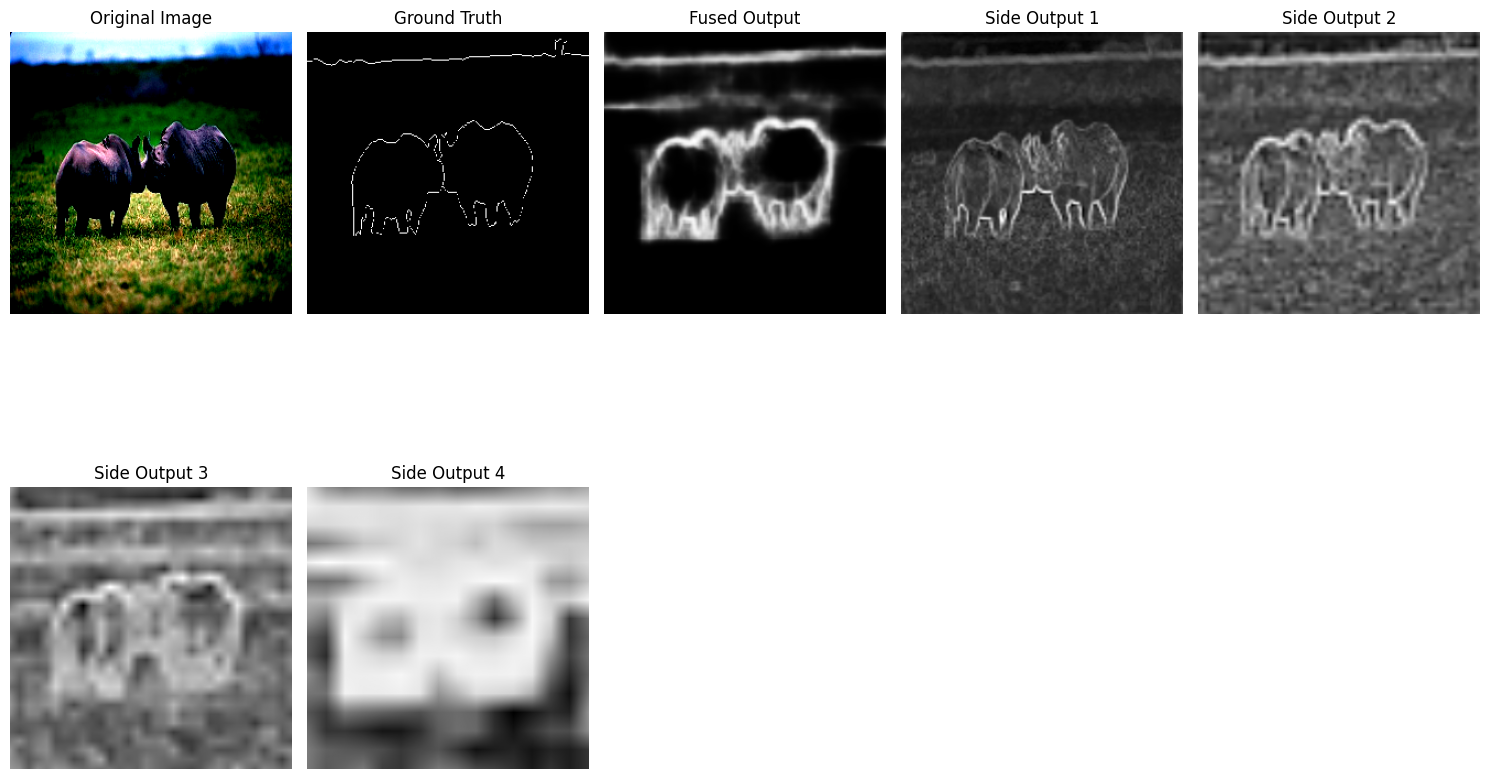

In [ ]:
import torch
import matplotlib.pyplot as plt

X_test_tensor = torch.stack([transform(img) for img in X_test])
y_test_tensor = torch.stack([transform_won(edge) for edge in y_test])
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
del X_test_tensor, y_test_tensor

# Select the first 5 test images
model.eval()
images, labels = next(iter(test_loader))
images, labels = images[:5].to(device), labels[:5].to(device)

# Normalization parameters used during preprocessing
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
# Function to denormalize
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, -1, 1, 1)  # Reshape for broadcasting
    std = torch.tensor(std).view(1, -1, 1, 1)    # Reshape for broadcasting
    return tensor * std + mean


# Forward pass
fused_output, upsampled_outputs = model(images)


# Visualize outputs for the first image in the batch
image = images[2].cpu().permute(1, 2, 0) # Convert to (H, W, C) for visualization
label = labels[2].cpu()  # Ground truth label map
fused_output_np = torch.sigmoid(fused_output[2]).detach().cpu().squeeze(0).numpy()  # Fused output (after sigmoid)

# Plot original image and ground truth
plt.figure(figsize=(15, 10))
plt.subplot(2, len(upsampled_outputs) + 1, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(2, len(upsampled_outputs) + 1, 2)
plt.imshow(label.cpu().squeeze().numpy(), cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

# Plot fused output
plt.subplot(2, len(upsampled_outputs) + 1, 3)
plt.imshow(fused_output_np, cmap='gray')
plt.title("Fused Output")
plt.axis('off')

# Plot side outputs
for idx, side_output in enumerate(upsampled_outputs):
    side_output_np = side_output[2].squeeze(0).detach().cpu().numpy()  # Apply sigmoid and convert to numpy
    
    plt.subplot(2, len(upsampled_outputs) + 1, idx + 4)
    plt.imshow(side_output_np, cmap='gray')
    plt.title(f"Side Output {idx + 1}")
    plt.axis('off')



# Display learned fusion weights
fusion_weights =  torch.softmax(model.weights, dim=0).detach().cpu().numpy()
print("Learned Fusion Weights:", fusion_weights)

plt.tight_layout()
plt.show()





#### The final model demonstrates state-of-the-art performance by combining multiscale features with class-balancing loss functions, making it ideal for detecting important edges as defined by ground truth. In comparison:

#### VGG16 performs well but lacks the refinement provided by fusion layers in the final model.
#### Simple CNN struggles with edge detection tasks due to its limited feature extraction capabilities.

#### HED significantly outperforms Canny by leveraging deep learning for robust edge detection, but it requires higher computational resources.
